## **Deepfake Detection with a Convolutional Neural Network**
Daniel Radunsky, Adam Torres Encarnacion

#### **Import Packages**

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np

#### **Unzip Files (Only if Needed, Works Faster than Windows)**

In [ ]:
import zipfile
from pathlib import Path
from tqdm import tqdm

def unzip_file(zip_path, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get a list of all the files in the zip archive
        files = zip_ref.namelist()
        
        # Show progress bar while extracting
        for file in tqdm(files, desc="Unzipping", unit="file"):
            zip_ref.extract(file, output_dir)

# Path to the zip file
zip_path = Path(r"c:\Users\kingd\Downloads\Dataset.zip")
# Directory to extract to
output_dir = Path("./data")

# Unzip the file
unzip_file(zip_path, output_dir)

#### **Load Data**

In [ ]:
train_dir = './data/Train'
test_dir = './data/Test'

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # RESIZE TO 128X128
    transforms.ToTensor(),  # MAKE THE IMAGES TENSORS
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # NORMALIZE PICTURES
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

real_class_idx = train_dataset.class_to_idx['Real']
fake_class_idx = train_dataset.class_to_idx['Fake']

real_train_indices = [i for i, target in enumerate(train_dataset.targets) if target == real_class_idx]
fake_train_indices = [i for i, target in enumerate(train_dataset.targets) if target == fake_class_idx]
train_indices = real_train_indices[:20000] + fake_train_indices[:20000]

real_test_indices = [i for i, target in enumerate(test_dataset.targets) if target == real_class_idx]
fake_test_indices = [i for i, target in enumerate(test_dataset.targets) if target == fake_class_idx]
test_indices = real_test_indices[:5000] + fake_test_indices[:5000]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# LOAD IN TRAIN/TEST DATA
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

#### **Architecture**

In [ ]:
'''class Detector(nn.Module):
    def __init__(self):
        super(Detector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1),  # CONVOLUTIONAL LAYER 1 (3 KERNEL SIZE , 1 STRIDE)
            nn.ReLU(), # RELU ACTIVATION FOR LAYER 1
            nn.Conv2d(16, 4, 1), # CONVOLUTIONAL LAYER 2
            nn.ReLU(), # RELU ACTIVATION FOR LAYER 2
            nn.BatchNorm2d(4), # NORMALIZE VALUES (4 FEATURES)
            nn.MaxPool2d(8, 8) # MAX POOLING (8 KERNEL SIZE, 8 STRIDE)
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), # HELPS WITH OVERFITTING
            nn.Linear(4 * 15 * 15, 1),
            nn.Sigmoid()  # NORMALIZE TO [0,1] RANGE
        )

    def forward(self, x): # FEEDFORWARD PHASE
        x = self.features(x)
        x = self.classifier(x)
        return x'''

In [ ]:
class Detector(nn.Module):
    def __init__(self):
        super(Detector, self).__init__()

        # CONVOLUTIONAL LAYER 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # NORMALIZE BATCH
        self.pool1 = nn.MaxPool2d(3) # MAXPOOL W/ KERNEL SIZE 3
        self.dropout1 = nn.Dropout(0.5) # 50% DROPOUT

        # CONVOLUTIONAL LAYER 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # NORMALIZE BATCH
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) # NORMALIZE BATCH
        self.pool2 = nn.MaxPool2d(2) # MAXPOOL W/ KERNEL SIZE 2
        self.dropout2 = nn.Dropout(0.5) # 50% DROPOUT
        
        # CONVOLUTIONAL LAYER 3
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128) # NORMALIZE BATCH
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128) 
        self.pool3 = nn.MaxPool2d(2) # MAXPOOL W/ KERNEL SIZE 2
        self.dropout3 = nn.Dropout(0.25) # 25% DROPOUT
        
        # FULLY CONNECTED LAYER
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12800, 1024) # FEATURE MAP SIZE
        self.bn6 = nn.BatchNorm1d(1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1)
        
    # FEEDFORWARD PHASE
    def forward(self, x):
        # CONVOLUTIONAL LAYER 1
        x = F.relu(self.bn1(self.conv1(x))) # RELU FUNCTION
        x = self.pool1(x)
        x = self.dropout1(x) # APPLY DROPOUT
        
        # CONVOLUTIONAL LAYER 2
        x = F.relu(self.bn2(self.conv2(x))) # RELU
        x = F.relu(self.bn3(self.conv3(x))) # RELU
        x = self.pool2(x)
        x = self.dropout2(x) # APPLY DROPOUT
        
        # CONVOLUTIONAL LAYER 3
        x = F.relu(self.bn4(self.conv4(x))) # RELU FUNCTION
        x = F.relu(self.bn5(self.conv5(x))) # RELU FUNCTION
        x = self.pool3(x) # APPLY POOLING
        x = self.dropout3(x) # APPLY DROPOUT
        
        # FULLY CONNECTED LAYER
        x = self.flatten(x)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = torch.sigmoid(self.fc2(x)) # SIGMOID TO NORMALIZE [0,1]
        return x

#### **GPU Optimization**

In [169]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # OPTIMIZE TO GPU
print(device)
model = Detector().to(device)

cuda


#### **Calculate Accuracy**

In [170]:
criterion = nn.BCELoss() # BINARY CROSS ENTROPY LOSS (BINARY CLASSIFICATION FOR REAL/FAKE)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) # LOW LR ADAM OPTIMIZER

def calculate_accuracy(outputs, labels): 
    predicted = (outputs > 0.5).float() # VALUES CLOSER TO 0 ARE FAKE, CLOSER TO 1 ARE REAL
    correct = (predicted == labels).sum().item() 
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


#### **Training/Testing Loop**

In [171]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10
for epoch in range(num_epochs): # 10 EPOCHS
    model.train() # TRAINING LOOP
    current_loss = 0.0
    running_corrects = 0

    
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad() # SET GRADIENTS TO ZERO

        outputs = model(images) 
        loss = criterion(outputs.squeeze(), labels)

        loss.backward() # BACKPROPAGATION
        optimizer.step()

        current_loss += loss.item() # CALCULATE LOSS VALUE THROUGHOUT TRAINING
        running_corrects += calculate_accuracy(outputs.squeeze(), labels)  

    
    train_loss = current_loss / len(train_loader) # TRAINING LOSS
    train_accuracy = running_corrects / len(train_loader) # TRAINING ACCURACY

   
    model.eval()
    current_loss = 0.0
    current_correct = 0
    total_samples = 0

    # TESTING LOOP
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            current_loss += loss.item() 
            current_correct += calculate_accuracy(outputs.squeeze(), labels) 
            total_samples += labels.size(0)
        
    test_loss = current_loss / len(test_loader)
    test_accuracy = current_correct / len(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    
    print(f"Epoch {epoch + 1}:")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {100 * test_accuracy:.2f}%")

Epoch 1:
Training Loss: 0.4475, Training Accuracy: 78.70%
Testing Loss: 0.3703, Testing Accuracy: 66.27%
Epoch 2:
Training Loss: 0.3298, Training Accuracy: 85.33%
Testing Loss: 0.3045, Testing Accuracy: 74.68%
Epoch 3:
Training Loss: 0.2740, Training Accuracy: 88.31%
Testing Loss: 0.3112, Testing Accuracy: 79.87%
Epoch 4:
Training Loss: 0.2307, Training Accuracy: 90.21%
Testing Loss: 0.3601, Testing Accuracy: 83.09%
Epoch 5:
Training Loss: 0.2092, Training Accuracy: 91.39%
Testing Loss: 0.2172, Testing Accuracy: 83.80%
Epoch 6:
Training Loss: 0.1884, Training Accuracy: 92.10%
Testing Loss: 0.1500, Testing Accuracy: 84.13%
Epoch 7:
Training Loss: 0.1740, Training Accuracy: 92.92%
Testing Loss: 0.1990, Testing Accuracy: 83.93%
Epoch 8:
Training Loss: 0.1602, Training Accuracy: 93.53%
Testing Loss: 0.1451, Testing Accuracy: 83.97%
Epoch 9:
Training Loss: 0.1474, Training Accuracy: 94.04%
Testing Loss: 0.1200, Testing Accuracy: 82.80%
Epoch 10:
Training Loss: 0.1425, Training Accuracy: 94.

In [172]:
print("Train Losses: ", train_losses)
print("Train Accuracies: ", train_accuracies)

print("Test Losses: ", test_losses)
print("Test Accuracies: ", test_accuracies)

Train Losses:  [0.44749737141132356, 0.32983715922236445, 0.2739530639052391, 0.2306885313183069, 0.20923703946471214, 0.1883759422749281, 0.1740090962290764, 0.1602078986287117, 0.14742100633084773, 0.1424818656757474]
Train Accuracies:  [0.78705, 0.8533, 0.88305, 0.902075, 0.913925, 0.920975, 0.92915, 0.93535, 0.940375, 0.94245]
Test Losses:  [0.37027156352996826, 0.30445587635040283, 0.31115320324897766, 0.3601224720478058, 0.2171623408794403, 0.15002064406871796, 0.19897150993347168, 0.14512039721012115, 0.11997048556804657, 0.0709179937839508]
Test Accuracies:  [0.6627396166134185, 0.7468051118210862, 0.7987220447284346, 0.830870607028754, 0.8379592651757188, 0.8412539936102237, 0.8392571884984026, 0.8396565495207667, 0.8279752396166135, 0.847444089456869]


#### **Plot Train/Test Loss**

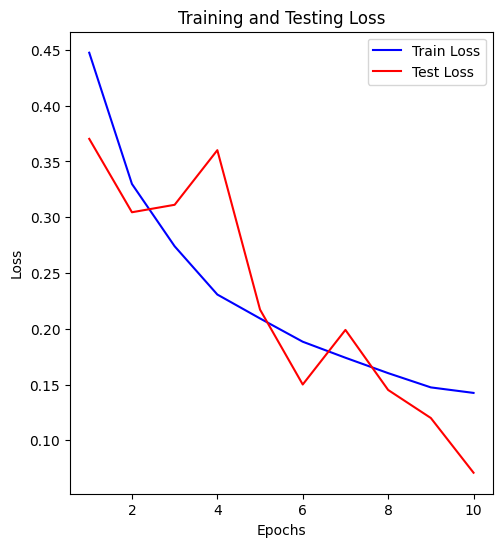

In [173]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

#### **Plot Train/Test Accuracy**

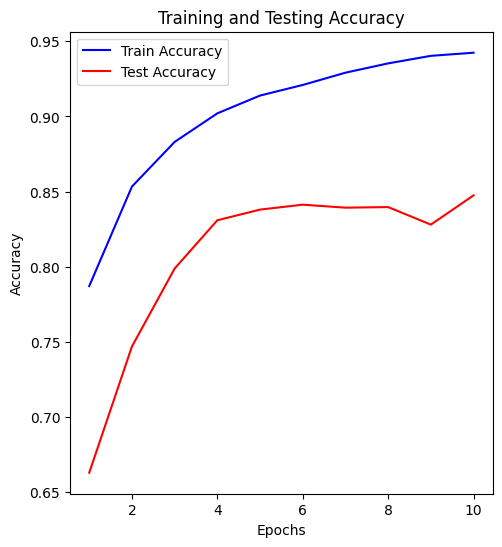

In [174]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()
